# AbDb Data Analysis

The metadata files have been downloaded from http://www.abybank.org/abdb/ using the "Complete Antibodies - Martin Numbering - Non Redundant (NR)" Dataset. (10.05.2022)

In [1]:
import pandas as pd
import yaml
import os

In [2]:
from abag_affinity.utils.config import read_yaml, get_data_paths

config = read_yaml("../../abag_affinity/config.yaml")
summary_path, pdb_path = get_data_paths(config, "AbDb")

In [3]:
if os.path.exists(summary_path):
    abdb_df = pd.read_csv(summary_path)
else:
    abdb_df = pd.DataFrame()
abdb_df.head()

,Unnamed: 0.1,Unnamed: 0,abdb_filename,pdb,antibody_chains,antigen_chains,in_dataset,dG (REU),dG (REU)-double_relax
0,0,0,5IES_1.pdb,5ies,"['L', 'H']",['C'],True,-6.558715,-3.631291
1,1,1,2HFG_1.pdb,2hfg,"['L', 'H']",['R'],True,-110.869807,-43.817577
2,2,2,3O6L_1.pdb,3o6l,"['L', 'H']",['C'],True,-68.280188,-19.465279
3,3,3,5BK1_2.pdb,5bk1,"['L', 'H']",['B'],True,-65.538385,-39.382892
4,4,4,4NP4_1.pdb,4np4,"['L', 'H']",['A'],True,-96.312982,-22.272860


In [4]:
pdb_files = os.listdir(pdb_path)

print("Number of PDB Files >>>", len(pdb_files))

Number of PDB Files >>> 1229


In [5]:
pdb_files[:5]

['6N5E_1.pdb', '4TTD_1.pdb', '5B3J_2.pdb', '1QGC_1.pdb', '3CX5_1.pdb']

In [6]:
if len(abdb_df) == 0:
    abdb_df["abdb_filename"] = pdb_files
    pdb_ids = [pdb_file.split("_")[0].lower() for pdb_file in pdb_files]

    abdb_df["pdb"] = pdb_ids

In [7]:
abdb_df.head()

,Unnamed: 0.1,Unnamed: 0,abdb_filename,pdb,antibody_chains,antigen_chains,in_dataset,dG (REU),dG (REU)-double_relax
0,0,0,5IES_1.pdb,5ies,"['L', 'H']",['C'],True,-6.558715,-3.631291
1,1,1,2HFG_1.pdb,2hfg,"['L', 'H']",['R'],True,-110.869807,-43.817577
2,2,2,3O6L_1.pdb,3o6l,"['L', 'H']",['C'],True,-68.280188,-19.465279
3,3,3,5BK1_2.pdb,5bk1,"['L', 'H']",['B'],True,-65.538385,-39.382892
4,4,4,4NP4_1.pdb,4np4,"['L', 'H']",['A'],True,-96.312982,-22.272860


## PDB Files with no affinity value

Get all entries that are not part of the dataset_v1 (overlap of AbDb and SAbDab or Antibody Benchmark)

In [8]:
dataset_summary_path, _ = get_data_paths(config, "Dataset_v1")
dataset_df = pd.read_csv(dataset_summary_path)
dataset_df.head()

,index,pdb,abdb_file,antigen_type,antibody_chains,antigen_chains,affinity_method,temperature,calculated_temp,affinity,delta_g,test,validation
0,0,2r56,2R56_1.pdb,protein,"['I', 'M', 'H', 'L']","['B', 'A']",SPR,NaN,25.0,1.300000e-09,-12.120000,False,2
1,271,3l5x,3L5X_1.pdb,protein,"['H', 'L']",['A'],SPR,25,25.0,2.690000e-10,-13.050000,False,3
2,270,3sdy,3SDY_1.pdb,protein | protein,"['H', 'L']","['B', 'A']",Other,30,30.0,1.000000e-09,-12.480000,False,3
3,269,5i5k,5I5K_1.pdb,protein,"['X', 'Y', 'H', 'L']","['A', 'B']",SPR,NaN,25.0,1.760000e-11,-14.671746,False,3
4,268,3kr3,3KR3_1.pdb,protein,"['H', 'L']",['D'],SPR,25,25.0,4.900000e-11,-14.060000,False,2


In [9]:
abdb_df["in_dataset"] = False
abdb_df.loc[abdb_df["pdb"].isin(dataset_df["pdb"]), "in_dataset"] = True

In [10]:
print("PDB Files that are not in dataset v1 >>> {}".format(abdb_df["in_dataset"].count() - abdb_df["in_dataset"].sum()))

PDB Files that are not in dataset v1 >>> 804


In [11]:
import warnings
warnings.filterwarnings("ignore")
from abag_affinity.utils.pdb_reader import read_file

def get_chain_ids(row):
    pdb_id = row["pdb"]
    path = os.path.join(pdb_path, row["abdb_filename"])
    
    structure, header = read_file(pdb_id, path)
    
    chain_ids = []
    for chain in structure.get_chains():
        chain_ids.append(chain.id)
    return chain_ids

def check_LH_chains(row):
    if "L" in row["chains"] and "H" in row["chains"]:
        return True
    else:
        return False

In [12]:
from tqdm.auto import tqdm
tqdm.pandas()

if "antibody_chains" not in abdb_df.columns and "chains" not in abdb_df.columns:
    abdb_df["chains"] = abdb_df.apply(lambda row: get_chain_ids(row), axis=1)
if "antibody_chains" not in abdb_df.columns and "LH_exist" not in abdb_df.columns:
    abdb_df["LH_exist"] = abdb_df.apply(lambda row: check_LH_chains(row), axis=1)
    print("PDB Files where chain L and H do not exist >>> {}".format(abdb_df["LH_exist"].count() - abdb_df["LH_exist"].sum()))

In [13]:
if "antibody_chains" not in abdb_df.columns:
    abdb_df["antibody_chains"] = [["L", "H"] for i in abdb_df.index]

In [14]:
def get_antigen_chains(row):
    antigen_chains = set(row["chains"]) - set(row["antibody_chains"])
    return list(antigen_chains)

if "antigen_chains" not in abdb_df.columns:
    abdb_df["antigen_chains"] = abdb_df.apply(lambda row: get_antigen_chains(row), axis=1)

In [15]:
abdb_df = abdb_df[["abdb_filename", "pdb", "antibody_chains", "antigen_chains", "in_dataset", "dG (REU)", "dG (REU)-double_relax"]]

abdb_df.head()

,abdb_filename,pdb,antibody_chains,antigen_chains,in_dataset,dG (REU),dG (REU)-double_relax
0,5IES_1.pdb,5ies,"['L', 'H']",['C'],True,-6.558715,-3.631291
1,2HFG_1.pdb,2hfg,"['L', 'H']",['R'],True,-110.869807,-43.817577
2,3O6L_1.pdb,3o6l,"['L', 'H']",['C'],True,-68.280188,-19.465279
3,5BK1_2.pdb,5bk1,"['L', 'H']",['B'],True,-65.538385,-39.382892
4,4NP4_1.pdb,4np4,"['L', 'H']",['A'],True,-96.312982,-22.272860


In [16]:
abdb_df = abdb_df.sort_values(by="in_dataset", ascending=False)

#abdb_df.to_csv(summary_path, index=False)

## Analysis of computed Affinity values

In [17]:
dg_rosetta_col = "dG (REU)"


abdb_df_dg = abdb_df[~abdb_df[dg_rosetta_col].isna()].set_index("pdb")

dataset_df_pdb = dataset_df.set_index("pdb")

joined_df = abdb_df_dg.join(dataset_df_pdb, how="inner", lsuffix="_abdb")

joined_df = joined_df[[dg_rosetta_col, "affinity", "delta_g", "temperature", "calculated_temp"]]

In [18]:
# remove outiers 
# outliers have a zscroe above 3

import numpy as np
from scipy import stats
joined_df = joined_df[(np.abs(stats.zscore(joined_df[dg_rosetta_col])) < 3)]

In [19]:
joined_df.head()

,dG (REU),affinity,delta_g,temperature,calculated_temp
pdb,,,,,
1dqj,-71.985677,2.860000e-09,-11.450000,25,20.0
1iqd,-65.503166,1.400000e-11,-14.800000,NaN,25.0
1nl0,-73.422605,1.600000e-09,-11.999727,NaN,25.0
1tzh,-79.108244,1.800000e-09,-12.400000,37,37.0
1w72,-78.111531,1.400000e-08,-10.710000,SPR,25.0


In [20]:
joined_df[dg_rosetta_col].corr(joined_df["affinity"])

0.04355318398098038

In [21]:
joined_df[dg_rosetta_col].corr(joined_df["delta_g"])

0.17437330166258402

<AxesSubplot:xlabel='delta_g', ylabel='dG (REU)'>

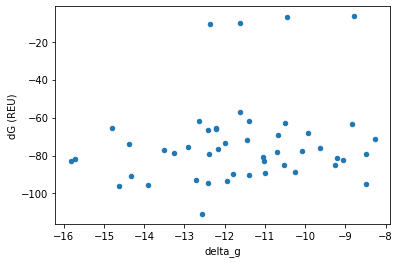

In [22]:
joined_df.plot.scatter("delta_g", dg_rosetta_col)

##### Fit Linear Model to convert dg (REU) to affinity values

In [23]:
from sklearn.linear_model import LinearRegression
import numpy as np


X = joined_df.loc[:, dg_rosetta_col].values.reshape(-1, 1) 
Y = joined_df.loc[:, "delta_g"].values.reshape(-1, 1) 

linear_regressor = LinearRegression()  
linear_regressor.fit(X, Y)  
joined_df["predicted_dg"] = linear_regressor.predict(X) 

In [24]:
joined_df["delta_g"].corr(joined_df["predicted_dg"])

0.17437330166258402

<AxesSubplot:xlabel='delta_g', ylabel='predicted_dg'>

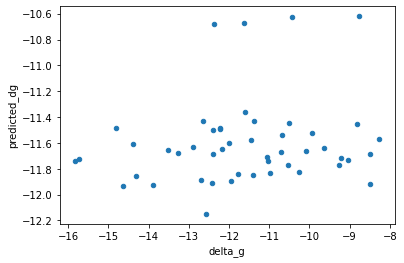

In [25]:
joined_df.plot.scatter("delta_g", "predicted_dg")